**Imports and includes**

In [1]:
import csv
import numpy as np 
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt 
import pickle
import statistics
import numpy as np  
import sys
import glob

pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 200)

In [2]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

**Sentiment analysis function provided by Upasana**

In [4]:
def sentiment_analyzer_score_for_englishOnlyTweet(cleaned_tweet): #this function takes in a tweet that has been detected as an english tweet
    score = analyser.polarity_scores(cleaned_tweet) #so this cleaned_tweet is always an english tweet.
    lb = score['compound']
    return lb

**Create list of all Baseline Users**

In [5]:
all_user_lists=[
    "/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/DidNotMentionBack_Users/Filtered_EnglishUsers_DidNotMentionedBackUsers_FINAL.csv",
    "/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/MentionedBack_Users/Filtered_EnglishUsers_MentionedBackUsers_FINAL.csv",
    '../BeforeAndAfterAnalysis/Filtered_EnglishUsers_DidnotMentionBackUsers.csv',
    '../BeforeAndAfterAnalysis/Filtered_EnglishUsers_MentionBackedUsers.csv']

UserList = []
userPathDict = {}
for i in range(4):  
    df = pd.read_csv(all_user_lists[i])
    tempUserList = list(df['Users'])
    for j in range(len(tempUserList)):
        UserList.append(tempUserList[j])
        if (i == 0) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'
        elif (i == 1) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'
        elif (i == 2) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'
        elif (i == 3) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'
    

In [6]:
print("Number of possibly affected users: " + str(len(UserList)))

Number of possibly affected users: 5472


In [7]:
# with open('pau_all.txt', 'w') as filehandle:
#     for listitem in UserList:
#         filehandle.write('%s\n' % listitem)

**Functions to check for a mention of Donald Trump or Hillary Clinton in a tweet**

In [8]:
def mentions_trump(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'realdonaldtrump':
                return True
    return False

In [9]:
def mentions_clinton(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'hillaryclinton':
                return True
    return False

**Calculate monthy values for each user (over the 96 months from Jan 2009 to December 2016)**

In [10]:
timelineDict = {}

In [11]:
firstTweetIndexDict = {}

In [12]:
timelineDF = pd.DataFrame(columns=['username','tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent',
                                      'positive_sent', 'negative_sent'])

In [13]:
size = str(len(UserList))
for i in range(len(UserList)):
# for i in range(100):
    try:
        #read in, reverse order (so oldest is first), reset index
        temp_user_db = pd.read_csv(userPathDict[UserList[i]]+UserList[i]+'.csv', header=None, low_memory=False)
        temp_user_db = temp_user_db.iloc[::-1]
        temp_user_db.reset_index(drop=True, inplace=True)

        #create lists for each metric
        tweet_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        trump_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        clinton_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        sentiment_scores = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        trump_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        clinton_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        positive_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        negative_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]

        #iterate through user tweets
        first = 1
        for j in range(len(temp_user_db)):

            #step one is assigning an index for the tweet, based on date, or disregarding
            found = 0
            tweetdate = dt.strptime(temp_user_db[3][j], "%Y-%m-%d")
            for k in range(2009,2017):
                temp_year = k
                date_start = dt(temp_year,1,1)
                date_end = dt(temp_year,12,31)
                if tweetdate < date_start:
                    continue;
                elif tweetdate <= date_end:
                    for m in range(2,14):
                        if m == 13: #month must be December by process of elimination
                            use_index = (((k-2009)*12)+(m-2))
                            found = 1
    #                         print(temp_user_db['date'][j] + " " +str(use_index))
                            break;
                        next_month_start = dt(temp_year,m,1)
                        if tweetdate < next_month_start:
                            use_index = (((k-2009)*12)+(m-2))
                            found = 1
    #                         print(temp_user_db['date'][j] + " " +str(use_index))
                            break;

            #tweet occurred within the period 2009-2016 and was assigned an valid index
            if found == 1:
                if first:
                    firstTweetIndexDict[UserList[i]] = use_index
                    first = 0

                tweet_count[use_index] +=1

                tweet_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
                sentiment_scores[use_index].append(tweet_sent)

                trump_flag = mentions_trump(str(temp_user_db[11][j]))
                clinton_flag = mentions_clinton(str(temp_user_db[11][j]))

                if trump_flag: trump_count[use_index] += 1
                if clinton_flag: clinton_count[use_index] += 1

                if trump_flag and not clinton_flag: trump_sent[use_index].append(tweet_sent)
                if clinton_flag and not trump_flag: clinton_sent[use_index].append(tweet_sent)

                if tweet_sent > 0: positive_sent[use_index].append(tweet_sent)
                if tweet_sent < 0: negative_sent[use_index].append(tweet_sent)

        timelineDict[UserList[i]] = [tweet_count, sentiment_scores, trump_count, clinton_count, 
                                     trump_sent, clinton_sent, positive_sent, negative_sent]

        print(str(i) + " / " + size)

    except Exception as e: 
        print(str(UserList[i]) + " failed - " + str(e))

        

0 / 5472
1 / 5472
2 / 5472
3 / 5472
4 / 5472
5 / 5472
6 / 5472
7 / 5472
8 / 5472
9 / 5472
10 / 5472
11 / 5472
12 / 5472
13 / 5472
14 / 5472
15 / 5472
16 / 5472
17 / 5472
18 / 5472
19 / 5472
20 / 5472
21 / 5472
22 / 5472
23 / 5472
24 / 5472
25 / 5472
26 / 5472
27 / 5472
28 / 5472
29 / 5472
30 / 5472
31 / 5472
32 / 5472
33 / 5472
34 / 5472
35 / 5472
36 / 5472
37 / 5472
38 / 5472
39 / 5472
40 / 5472
41 / 5472
42 / 5472
43 / 5472
44 / 5472
45 / 5472
46 / 5472
47 / 5472
48 / 5472
49 / 5472
50 / 5472
51 / 5472
52 / 5472
53 / 5472
54 / 5472
55 / 5472
56 / 5472
57 / 5472
58 / 5472
59 / 5472
60 / 5472
61 / 5472
62 / 5472
63 / 5472
64 / 5472
65 / 5472
66 / 5472
67 / 5472
68 / 5472
69 / 5472
70 / 5472
71 / 5472
72 / 5472
73 / 5472
74 / 5472
75 / 5472
76 / 5472
77 / 5472
78 / 5472
79 / 5472
80 / 5472
81 / 5472
82 / 5472
83 / 5472
84 / 5472
85 / 5472
86 / 5472
87 / 5472
88 / 5472
89 / 5472
90 / 5472
91 / 5472
92 / 5472
93 / 5472
94 / 5472
95 / 5472
96 / 5472
97 / 5472
98 / 5472
99 / 5472
100 / 5472

755 / 5472
756 / 5472
757 / 5472
758 / 5472
759 / 5472
760 / 5472
761 / 5472
762 / 5472
763 / 5472
764 / 5472
765 / 5472
766 / 5472
767 / 5472
768 / 5472
769 / 5472
770 / 5472
771 / 5472
772 / 5472
773 / 5472
774 / 5472
775 / 5472
776 / 5472
777 / 5472
778 / 5472
779 / 5472
780 / 5472
781 / 5472
782 / 5472
783 / 5472
784 / 5472
785 / 5472
786 / 5472
787 / 5472
788 / 5472
789 / 5472
790 / 5472
791 / 5472
792 / 5472
793 / 5472
794 / 5472
795 / 5472
796 / 5472
797 / 5472
798 / 5472
799 / 5472
800 / 5472
801 / 5472
802 / 5472
803 / 5472
804 / 5472
805 / 5472
806 / 5472
807 / 5472
808 / 5472
809 / 5472
810 / 5472
811 / 5472
812 / 5472
813 / 5472
814 / 5472
815 / 5472
816 / 5472
817 / 5472
818 / 5472
819 / 5472
820 / 5472
821 / 5472
822 / 5472
823 / 5472
824 / 5472
825 / 5472
826 / 5472
827 / 5472
828 / 5472
829 / 5472
830 / 5472
831 / 5472
832 / 5472
833 / 5472
834 / 5472
835 / 5472
836 / 5472
837 / 5472
838 / 5472
839 / 5472
840 / 5472
841 / 5472
842 / 5472
843 / 5472
844 / 5472
845 / 5472

1459 / 5472
1460 / 5472
1461 / 5472
1462 / 5472
1463 / 5472
1464 / 5472
1465 / 5472
1466 / 5472
1467 / 5472
1468 / 5472
1469 / 5472
1470 / 5472
1471 / 5472
1472 / 5472
1473 / 5472
1474 / 5472
1475 / 5472
1476 / 5472
1477 / 5472
1478 / 5472
1479 / 5472
1480 / 5472
1481 / 5472
1482 / 5472
1483 / 5472
1484 / 5472
1485 / 5472
1486 / 5472
1487 / 5472
1488 / 5472
1489 / 5472
1490 / 5472
1491 / 5472
1492 / 5472
1493 / 5472
1494 / 5472
1495 / 5472
1496 / 5472
1497 / 5472
1498 / 5472
1499 / 5472
1500 / 5472
1501 / 5472
1502 / 5472
1503 / 5472
1504 / 5472
1505 / 5472
1506 / 5472
1507 / 5472
1508 / 5472
1509 / 5472
1510 / 5472
1511 / 5472
1512 / 5472
1513 / 5472
1514 / 5472
1515 / 5472
1516 / 5472
1517 / 5472
1518 / 5472
1519 / 5472
1520 / 5472
1521 / 5472
1522 / 5472
1523 / 5472
1524 / 5472
1525 / 5472
1526 / 5472
1527 / 5472
1528 / 5472
1529 / 5472
1530 / 5472
1531 / 5472
1532 / 5472
1533 / 5472
1534 / 5472
1535 / 5472
1536 / 5472
1537 / 5472
1538 / 5472
1539 / 5472
1540 / 5472
1541 / 5472
1542

2142 / 5472
2143 / 5472
2144 / 5472
2145 / 5472
2146 / 5472
2147 / 5472
2148 / 5472
2149 / 5472
2150 / 5472
2151 / 5472
2152 / 5472
2153 / 5472
2154 / 5472
2155 / 5472
2156 / 5472
2157 / 5472
2158 / 5472
2159 / 5472
2160 / 5472
2161 / 5472
2162 / 5472
2163 / 5472
2164 / 5472
2165 / 5472
2166 / 5472
2167 / 5472
2168 / 5472
2169 / 5472
2170 / 5472
2171 / 5472
2172 / 5472
2173 / 5472
2174 / 5472
2175 / 5472
2176 / 5472
2177 / 5472
2178 / 5472
2179 / 5472
2180 / 5472
2181 / 5472
2182 / 5472
2183 / 5472
2184 / 5472
2185 / 5472
2186 / 5472
2187 / 5472
2188 / 5472
2189 / 5472
2190 / 5472
2191 / 5472
2192 / 5472
2193 / 5472
2194 / 5472
2195 / 5472
2196 / 5472
2197 / 5472
2198 / 5472
2199 / 5472
2200 / 5472
2201 / 5472
2202 / 5472
2203 / 5472
2204 / 5472
2205 / 5472
2206 / 5472
2207 / 5472
2208 / 5472
2209 / 5472
2210 / 5472
2211 / 5472
2212 / 5472
2213 / 5472
2214 / 5472
2215 / 5472
2216 / 5472
2217 / 5472
2218 / 5472
2219 / 5472
2220 / 5472
2221 / 5472
2222 / 5472
2223 / 5472
2224 / 5472
2225

2825 / 5472
2826 / 5472
2827 / 5472
2828 / 5472
2829 / 5472
2830 / 5472
2831 / 5472
2832 / 5472
2833 / 5472
2834 / 5472
2835 / 5472
2836 / 5472
2837 / 5472
2838 / 5472
2839 / 5472
2840 / 5472
2841 / 5472
2842 / 5472
2843 / 5472
2844 / 5472
2845 / 5472
2846 / 5472
2847 / 5472
2848 / 5472
2849 / 5472
2850 / 5472
2851 / 5472
2852 / 5472
2853 / 5472
2854 / 5472
2855 / 5472
2856 / 5472
2857 / 5472
2858 / 5472
2859 / 5472
2860 / 5472
2861 / 5472
2862 / 5472
2863 / 5472
2864 / 5472
2865 / 5472
2866 / 5472
2867 / 5472
2868 / 5472
2869 / 5472
2870 / 5472
2871 / 5472
2872 / 5472
2873 / 5472
2874 / 5472
2875 / 5472
2876 / 5472
2877 / 5472
2878 / 5472
2879 / 5472
2880 / 5472
2881 / 5472
2882 / 5472
2883 / 5472
2884 / 5472
2885 / 5472
2886 / 5472
2887 / 5472
2888 / 5472
2889 / 5472
2890 / 5472
2891 / 5472
2892 / 5472
2893 / 5472
2894 / 5472
2895 / 5472
2896 / 5472
2897 / 5472
2898 / 5472
2899 / 5472
2900 / 5472
2901 / 5472
2902 / 5472
2903 / 5472
2904 / 5472
2905 / 5472
2906 / 5472
2907 / 5472
2908

3508 / 5472
3509 / 5472
3510 / 5472
3511 / 5472
3512 / 5472
3513 / 5472
3514 / 5472
3515 / 5472
3516 / 5472
3517 / 5472
3518 / 5472
3519 / 5472
3520 / 5472
3521 / 5472
3522 / 5472
3523 / 5472
3524 / 5472
3525 / 5472
3526 / 5472
3527 / 5472
3528 / 5472
3529 / 5472
3530 / 5472
3531 / 5472
3532 / 5472
3533 / 5472
3534 / 5472
3535 / 5472
3536 / 5472
3537 / 5472
3538 / 5472
3539 / 5472
3540 / 5472
3541 / 5472
3542 / 5472
3543 / 5472
3544 / 5472
3545 / 5472
3546 / 5472
3547 / 5472
3548 / 5472
3549 / 5472
3550 / 5472
3551 / 5472
3552 / 5472
3553 / 5472
3554 / 5472
3555 / 5472
3556 / 5472
3557 / 5472
3558 / 5472
3559 / 5472
3560 / 5472
3561 / 5472
3562 / 5472
3563 / 5472
3564 / 5472
3565 / 5472
3566 / 5472
3567 / 5472
3568 / 5472
3569 / 5472
3570 / 5472
3571 / 5472
3572 / 5472
3573 / 5472
3574 / 5472
3575 / 5472
3576 / 5472
3577 / 5472
3578 / 5472
3579 / 5472
3580 / 5472
3581 / 5472
3582 / 5472
3583 / 5472
3584 / 5472
3585 / 5472
3586 / 5472
3587 / 5472
3588 / 5472
3589 / 5472
3590 / 5472
3591

4191 / 5472
4192 / 5472
4193 / 5472
4194 / 5472
4195 / 5472
4196 / 5472
4197 / 5472
4198 / 5472
4199 / 5472
4200 / 5472
4201 / 5472
4202 / 5472
4203 / 5472
4204 / 5472
4205 / 5472
4206 / 5472
4207 / 5472
4208 / 5472
4209 / 5472
4210 / 5472
4211 / 5472
4212 / 5472
4213 / 5472
4214 / 5472
4215 / 5472
4216 / 5472
4217 / 5472
4218 / 5472
4219 / 5472
4220 / 5472
4221 / 5472
4222 / 5472
4223 / 5472
4224 / 5472
4225 / 5472
4226 / 5472
4227 / 5472
4228 / 5472
4229 / 5472
4230 / 5472
4231 / 5472
4232 / 5472
4233 / 5472
4234 / 5472
4235 / 5472
4236 / 5472
4237 / 5472
4238 / 5472
4239 / 5472
4240 / 5472
4241 / 5472
4242 / 5472
4243 / 5472
4244 / 5472
4245 / 5472
4246 / 5472
4247 / 5472
4248 / 5472
4249 / 5472
4250 / 5472
4251 / 5472
4252 / 5472
4253 / 5472
4254 / 5472
4255 / 5472
4256 / 5472
4257 / 5472
4258 / 5472
4259 / 5472
4260 / 5472
4261 / 5472
4262 / 5472
4263 / 5472
4264 / 5472
4265 / 5472
4266 / 5472
4267 / 5472
4268 / 5472
4269 / 5472
4270 / 5472
4271 / 5472
4272 / 5472
4273 / 5472
4274

4874 / 5472
4875 / 5472
4876 / 5472
4877 / 5472
4878 / 5472
4879 / 5472
4880 / 5472
4881 / 5472
4882 / 5472
4883 / 5472
4884 / 5472
4885 / 5472
4886 / 5472
4887 / 5472
4888 / 5472
4889 / 5472
4890 / 5472
4891 / 5472
4892 / 5472
4893 / 5472
4894 / 5472
4895 / 5472
4896 / 5472
4897 / 5472
4898 / 5472
4899 / 5472
4900 / 5472
4901 / 5472
4902 / 5472
4903 / 5472
4904 / 5472
4905 / 5472
4906 / 5472
4907 / 5472
4908 / 5472
4909 / 5472
4910 / 5472
4911 / 5472
4912 / 5472
4913 / 5472
4914 / 5472
4915 / 5472
4916 / 5472
4917 / 5472
4918 / 5472
4919 / 5472
4920 / 5472
4921 / 5472
4922 / 5472
4923 / 5472
4924 / 5472
4925 / 5472
4926 / 5472
4927 / 5472
4928 / 5472
4929 / 5472
4930 / 5472
4931 / 5472
4932 / 5472
4933 / 5472
4934 / 5472
4935 / 5472
4936 / 5472
4937 / 5472
4938 / 5472
4939 / 5472
4940 / 5472
4941 / 5472
4942 / 5472
4943 / 5472
4944 / 5472
4945 / 5472
4946 / 5472
4947 / 5472
4948 / 5472
4949 / 5472
4950 / 5472
4951 / 5472
4952 / 5472
4953 / 5472
4954 / 5472
4955 / 5472
4956 / 5472
4957

In [14]:
len(firstTweetIndexDict)

5029

In [15]:
for i in range(len(timelineDF)):
    try:
        test = firstTweetIndexDict[timelineDF['username'][i]]
    except:
        print(timelineDF['username'][i] + ' failed [' +str(i)+']' )

In [16]:
timelineDF = pd.DataFrame.from_dict(timelineDict, orient='index',columns=['tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent',
                                      'positive_sent', 'negative_sent'])

timelineDF.index.name = 'username'
timelineDF.reset_index(inplace=True)


In [17]:
len(timelineDF)

5458

In [18]:
tweet_countDict = {}
sentiment_scoresDict = {}
trump_countDict = {}
clinton_countDict = {}
trump_sentDict = {}
clinton_sentDict = {}
positive_sentDict = {}
negative_sentDict = {} 

In [19]:
size = str(len(timelineDF))
for i in range(len(timelineDF)):
    try:
        start_index = firstTweetIndexDict[timelineDF['username'][i]]

        tweet_count = []
        sentiment_scores = []
        trump_count = []
        clinton_count = []
        trump_sent = []
        clinton_sent = []
        positive_sent = []
        negative_sent = [] 

        for j in range(0,96):
            if j >= start_index:
                tweet_count.append(timelineDF['tweet_count'][i][j])
                trump_count.append(timelineDF['trump_count'][i][j])
                clinton_count.append(timelineDF['clinton_count'][i][j])

                if(len(timelineDF['sentiment_scores'][i][j]) > 0):
                    sentiment_scores.append(statistics.mean(timelineDF['sentiment_scores'][i][j]))
                else:
                    sentiment_scores.append(np.nan)

                if(len(timelineDF['trump_sent'][i][j]) > 0):
                    trump_sent.append(statistics.mean(timelineDF['trump_sent'][i][j]))
                else:
                    trump_sent.append(np.nan)

                if(len(timelineDF['clinton_sent'][i][j]) > 0):
                    clinton_sent.append(statistics.mean(timelineDF['clinton_sent'][i][j]))
                else:
                    clinton_sent.append(np.nan)

                if(len(timelineDF['positive_sent'][i][j]) > 0):
                    positive_sent.append(statistics.mean(timelineDF['positive_sent'][i][j]))
                else:
                    positive_sent.append(np.nan)

                if(len(timelineDF['negative_sent'][i][j]) > 0):
                    negative_sent.append(statistics.mean(timelineDF['negative_sent'][i][j]))
                else:
                    negative_sent.append(np.nan)

            else:
                tweet_count.append(np.nan)
                trump_count.append(np.nan)
                clinton_count.append(np.nan)
                sentiment_scores.append(np.nan)
                trump_sent.append(np.nan)
                clinton_sent.append(np.nan)
                positive_sent.append(np.nan)
                negative_sent.append(np.nan)

        tweet_countDict[timelineDF['username'][i]] = tweet_count
        sentiment_scoresDict[timelineDF['username'][i]] = sentiment_scores
        trump_countDict[timelineDF['username'][i]] = trump_count
        clinton_countDict[timelineDF['username'][i]] = clinton_count
        trump_sentDict[timelineDF['username'][i]] = trump_sent
        clinton_sentDict[timelineDF['username'][i]] = clinton_sent
        positive_sentDict[timelineDF['username'][i]] = positive_sent
        negative_sentDict[timelineDF['username'][i]] =  negative_sent 

        print(str(i) + " / " + size)
        
    except Exception as e: 
        print(str(timelineDF['username'][i]) + " failed - " + str(e))

0 / 5458
1 / 5458
2 / 5458
3 / 5458
4 / 5458
5 / 5458
6 / 5458
7 / 5458
8 / 5458
9 / 5458
10 / 5458
11 / 5458
12 / 5458
13 / 5458
14 / 5458
rjames1928 failed - 'rjames1928'
16 / 5458
17 / 5458
18 / 5458
19 / 5458
20 / 5458
DocPakistan failed - 'DocPakistan'
22 / 5458
23 / 5458
24 / 5458
25 / 5458
26 / 5458
27 / 5458
28 / 5458
29 / 5458
30 / 5458
31 / 5458
32 / 5458
33 / 5458
34 / 5458
35 / 5458
36 / 5458
37 / 5458
38 / 5458
39 / 5458
40 / 5458
41 / 5458
42 / 5458
43 / 5458
44 / 5458
45 / 5458
46 / 5458
47 / 5458
48 / 5458
49 / 5458
50 / 5458
51 / 5458
52 / 5458
53 / 5458
54 / 5458
55 / 5458
56 / 5458
57 / 5458
58 / 5458
jdelreal failed - 'jdelreal'
60 / 5458
61 / 5458
62 / 5458
63 / 5458
64 / 5458
65 / 5458
66 / 5458
67 / 5458
68 / 5458
leithfadel failed - 'leithfadel'
70 / 5458
Nancys_News failed - 'Nancys_News'
72 / 5458
73 / 5458
74 / 5458
75 / 5458
76 / 5458
77 / 5458
78 / 5458
79 / 5458
80 / 5458
81 / 5458
82 / 5458
greta failed - 'greta'
84 / 5458
85 / 5458
86 / 5458
87 / 5458
88

630 / 5458
631 / 5458
632 / 5458
633 / 5458
634 / 5458
635 / 5458
636 / 5458
637 / 5458
BionicBombshell failed - 'BionicBombshell'
639 / 5458
640 / 5458
641 / 5458
642 / 5458
643 / 5458
644 / 5458
645 / 5458
646 / 5458
647 / 5458
648 / 5458
649 / 5458
650 / 5458
651 / 5458
652 / 5458
653 / 5458
654 / 5458
655 / 5458
656 / 5458
657 / 5458
658 / 5458
659 / 5458
tweettruth2me failed - 'tweettruth2me'
661 / 5458
Dreamweasel failed - 'Dreamweasel'
663 / 5458
664 / 5458
665 / 5458
666 / 5458
667 / 5458
668 / 5458
669 / 5458
670 / 5458
671 / 5458
672 / 5458
673 / 5458
674 / 5458
675 / 5458
676 / 5458
677 / 5458
678 / 5458
679 / 5458
680 / 5458
681 / 5458
682 / 5458
683 / 5458
684 / 5458
685 / 5458
686 / 5458
687 / 5458
688 / 5458
689 / 5458
690 / 5458
SeanMcElwee failed - 'SeanMcElwee'
692 / 5458
693 / 5458
694 / 5458
695 / 5458
696 / 5458
bsgirl2u failed - 'bsgirl2u'
698 / 5458
699 / 5458
700 / 5458
701 / 5458
702 / 5458
703 / 5458
704 / 5458
705 / 5458
706 / 5458
707 / 5458
708 / 5458
709 /

1250 / 5458
1251 / 5458
1252 / 5458
1253 / 5458
1254 / 5458
1255 / 5458
1256 / 5458
1257 / 5458
1258 / 5458
1259 / 5458
30SecondJams failed - '30SecondJams'
1261 / 5458
1262 / 5458
1263 / 5458
ScottFordTVGuy failed - 'ScottFordTVGuy'
Bloviate_Barbie failed - 'Bloviate_Barbie'
1266 / 5458
1267 / 5458
1268 / 5458
1269 / 5458
1270 / 5458
JebSanford failed - 'JebSanford'
1272 / 5458
1273 / 5458
BergaminiPaul failed - 'BergaminiPaul'
1275 / 5458
1276 / 5458
1277 / 5458
1278 / 5458
1279 / 5458
1280 / 5458
1281 / 5458
1282 / 5458
1283 / 5458
1284 / 5458
1285 / 5458
1286 / 5458
1287 / 5458
1288 / 5458
1289 / 5458
1290 / 5458
1291 / 5458
1292 / 5458
1293 / 5458
1294 / 5458
1295 / 5458
1296 / 5458
1297 / 5458
1298 / 5458
1299 / 5458
1300 / 5458
1301 / 5458
1302 / 5458
1303 / 5458
1304 / 5458
1305 / 5458
1306 / 5458
1307 / 5458
1308 / 5458
1309 / 5458
1310 / 5458
1311 / 5458
1312 / 5458
1313 / 5458
1314 / 5458
1315 / 5458
amandacarpenter failed - 'amandacarpenter'
1317 / 5458
1318 / 5458
1319 / 5

1843 / 5458
1844 / 5458
1845 / 5458
1846 / 5458
1847 / 5458
1848 / 5458
1849 / 5458
1850 / 5458
1851 / 5458
tackettdc failed - 'tackettdc'
1853 / 5458
1854 / 5458
1855 / 5458
1856 / 5458
1857 / 5458
1858 / 5458
1859 / 5458
1860 / 5458
1861 / 5458
1862 / 5458
1863 / 5458
1864 / 5458
1865 / 5458
RealCandaceO failed - 'RealCandaceO'
1867 / 5458
SandraHartle failed - 'SandraHartle'
1869 / 5458
1870 / 5458
1871 / 5458
1872 / 5458
1873 / 5458
1874 / 5458
1875 / 5458
1876 / 5458
1877 / 5458
1878 / 5458
1879 / 5458
1880 / 5458
1881 / 5458
1882 / 5458
1883 / 5458
1884 / 5458
1885 / 5458
1886 / 5458
SoCalMike_SD failed - 'SoCalMike_SD'
1888 / 5458
1889 / 5458
1890 / 5458
1891 / 5458
1892 / 5458
1893 / 5458
1894 / 5458
1895 / 5458
1896 / 5458
1897 / 5458
1898 / 5458
1899 / 5458
1900 / 5458
1901 / 5458
1902 / 5458
1903 / 5458
1904 / 5458
1905 / 5458
1906 / 5458
1907 / 5458
1908 / 5458
1909 / 5458
1910 / 5458
ColorMeRed failed - 'ColorMeRed'
1912 / 5458
1913 / 5458
truckerbooman failed - 'truckerbo

2436 / 5458
2437 / 5458
2438 / 5458
2439 / 5458
2440 / 5458
2441 / 5458
2442 / 5458
2443 / 5458
2444 / 5458
2445 / 5458
2446 / 5458
2447 / 5458
2448 / 5458
2449 / 5458
2450 / 5458
2451 / 5458
2452 / 5458
2453 / 5458
2454 / 5458
2455 / 5458
2456 / 5458
2457 / 5458
2458 / 5458
2459 / 5458
2460 / 5458
2461 / 5458
2462 / 5458
2463 / 5458
2464 / 5458
2465 / 5458
2466 / 5458
2467 / 5458
2468 / 5458
2469 / 5458
2470 / 5458
2471 / 5458
2472 / 5458
2473 / 5458
2474 / 5458
2475 / 5458
2476 / 5458
2477 / 5458
2478 / 5458
2479 / 5458
2480 / 5458
Dbargen failed - 'Dbargen'
austinkeller failed - 'austinkeller'
2483 / 5458
2484 / 5458
2485 / 5458
2486 / 5458
2487 / 5458
2488 / 5458
2489 / 5458
2490 / 5458
2491 / 5458
2492 / 5458
2493 / 5458
2494 / 5458
2495 / 5458
2496 / 5458
2497 / 5458
2498 / 5458
2499 / 5458
2500 / 5458
2501 / 5458
redhed67 failed - 'redhed67'
2503 / 5458
2504 / 5458
2505 / 5458
2506 / 5458
2507 / 5458
2508 / 5458
2509 / 5458
2510 / 5458
2511 / 5458
2512 / 5458
2513 / 5458
2514 / 

3042 / 5458
3043 / 5458
3044 / 5458
3045 / 5458
3046 / 5458
3047 / 5458
3048 / 5458
3049 / 5458
3050 / 5458
3051 / 5458
3052 / 5458
3053 / 5458
3054 / 5458
3055 / 5458
3056 / 5458
3057 / 5458
3058 / 5458
3059 / 5458
3060 / 5458
3061 / 5458
3062 / 5458
3063 / 5458
3064 / 5458
3065 / 5458
3066 / 5458
3067 / 5458
3068 / 5458
3069 / 5458
3070 / 5458
3071 / 5458
3072 / 5458
3073 / 5458
3074 / 5458
3075 / 5458
3076 / 5458
3077 / 5458
3078 / 5458
3079 / 5458
3080 / 5458
3081 / 5458
3082 / 5458
3083 / 5458
3084 / 5458
3085 / 5458
Saamprater failed - 'Saamprater'
3087 / 5458
3088 / 5458
3089 / 5458
3090 / 5458
3091 / 5458
3092 / 5458
3093 / 5458
3094 / 5458
3095 / 5458
3096 / 5458
3097 / 5458
3098 / 5458
3099 / 5458
3100 / 5458
3101 / 5458
3102 / 5458
3103 / 5458
3104 / 5458
TrydecafCoffey failed - 'TrydecafCoffey'
3106 / 5458
3107 / 5458
3108 / 5458
3109 / 5458
3110 / 5458
3111 / 5458
3112 / 5458
3113 / 5458
3114 / 5458
3115 / 5458
3116 / 5458
3117 / 5458
3118 / 5458
3119 / 5458
3120 / 5458
31

3658 / 5458
3659 / 5458
3660 / 5458
3661 / 5458
3662 / 5458
3663 / 5458
3664 / 5458
crookedgop failed - 'crookedgop'
3666 / 5458
Counselor70 failed - 'Counselor70'
3668 / 5458
3669 / 5458
3670 / 5458
3671 / 5458
3672 / 5458
Benderbr_rb failed - 'Benderbr_rb'
3674 / 5458
JohnFPLane failed - 'JohnFPLane'
3676 / 5458
NotEnoughHands failed - 'NotEnoughHands'
3678 / 5458
3679 / 5458
3680 / 5458
3681 / 5458
3682 / 5458
3683 / 5458
3684 / 5458
DolceNicole_ failed - 'DolceNicole_'
3686 / 5458
3687 / 5458
viradio failed - 'viradio'
3689 / 5458
3690 / 5458
3691 / 5458
3692 / 5458
3693 / 5458
3694 / 5458
POPCORN_C_MAPCA failed - 'POPCORN_C_MAPCA'
3696 / 5458
3697 / 5458
ShawtySuppaBad failed - 'ShawtySuppaBad'
3699 / 5458
3700 / 5458
3701 / 5458
3702 / 5458
3703 / 5458
TJDVET failed - 'TJDVET'
3705 / 5458
3706 / 5458
Gabi4Trump failed - 'Gabi4Trump'
3708 / 5458
3709 / 5458
3710 / 5458
3711 / 5458
3712 / 5458
3713 / 5458
3714 / 5458
3715 / 5458
3716 / 5458
3717 / 5458
3718 / 5458
3719 / 5458
3720 

4231 / 5458
chini_linguini failed - 'chini_linguini'
4233 / 5458
4234 / 5458
4235 / 5458
4236 / 5458
4237 / 5458
4238 / 5458
4239 / 5458
4240 / 5458
4241 / 5458
4242 / 5458
OlgaRyss1 failed - 'OlgaRyss1'
4244 / 5458
4245 / 5458
4246 / 5458
4247 / 5458
WmWallace1911 failed - 'WmWallace1911'
EveaFrank failed - 'EveaFrank'
4250 / 5458
DivaLoyal1 failed - 'DivaLoyal1'
4252 / 5458
4253 / 5458
4254 / 5458
4255 / 5458
4256 / 5458
4257 / 5458
4258 / 5458
4259 / 5458
4260 / 5458
4261 / 5458
4262 / 5458
tpel78 failed - 'tpel78'
4264 / 5458
4265 / 5458
4266 / 5458
4267 / 5458
4268 / 5458
4269 / 5458
4270 / 5458
4271 / 5458
4272 / 5458
4273 / 5458
4274 / 5458
4275 / 5458
4276 / 5458
4277 / 5458
4278 / 5458
4279 / 5458
4280 / 5458
4281 / 5458
4282 / 5458
4283 / 5458
4284 / 5458
4285 / 5458
4286 / 5458
4287 / 5458
4288 / 5458
4289 / 5458
4290 / 5458
4291 / 5458
4292 / 5458
4293 / 5458
4294 / 5458
4295 / 5458
TedMurray53 failed - 'TedMurray53'
4297 / 5458
4298 / 5458
4299 / 5458
4300 / 5458
4301 / 54

4787 / 5458
4788 / 5458
4789 / 5458
4790 / 5458
4791 / 5458
4792 / 5458
4793 / 5458
4794 / 5458
lauraroslin7 failed - 'lauraroslin7'
4796 / 5458
4797 / 5458
4798 / 5458
4799 / 5458
michael_house9 failed - 'michael_house9'
4801 / 5458
4802 / 5458
4803 / 5458
4804 / 5458
4805 / 5458
EintheD1 failed - 'EintheD1'
4807 / 5458
4808 / 5458
Its_What_I_Said failed - 'Its_What_I_Said'
4810 / 5458
4811 / 5458
4812 / 5458
4813 / 5458
4814 / 5458
4815 / 5458
4816 / 5458
4817 / 5458
4818 / 5458
4819 / 5458
4820 / 5458
drtpayz failed - 'drtpayz'
4822 / 5458
4823 / 5458
4824 / 5458
juanadamas95 failed - 'juanadamas95'
4826 / 5458
4827 / 5458
4828 / 5458
4829 / 5458
4830 / 5458
4831 / 5458
4832 / 5458
carolinebjerke2 failed - 'carolinebjerke2'
JamesMeroney failed - 'JamesMeroney'
4835 / 5458
4836 / 5458
4837 / 5458
4838 / 5458
4839 / 5458
4840 / 5458
4841 / 5458
4842 / 5458
4843 / 5458
4844 / 5458
4845 / 5458
4846 / 5458
4847 / 5458
4848 / 5458
4849 / 5458
4850 / 5458
4851 / 5458
4852 / 5458
4853 / 545

5429 / 5458
5430 / 5458
5431 / 5458
5432 / 5458
5433 / 5458
5434 / 5458
5435 / 5458
5436 / 5458
5437 / 5458
5438 / 5458
5439 / 5458
5440 / 5458
5441 / 5458
5442 / 5458
5443 / 5458
5444 / 5458
5445 / 5458
5446 / 5458
5447 / 5458
5448 / 5458
5449 / 5458
5450 / 5458
5451 / 5458
5452 / 5458
5453 / 5458
5454 / 5458
5455 / 5458
5456 / 5458
5457 / 5458


In [20]:
tweet_countDF = pd.DataFrame.from_dict(tweet_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
tweet_countDF.index.name = 'username'
tweet_countDF.reset_index(inplace=True)
tweet_countDF = tweet_countDF.drop(columns=['username'])

trump_countDF = pd.DataFrame.from_dict(trump_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
trump_countDF.index.name = 'username'
trump_countDF.reset_index(inplace=True)
trump_countDF = trump_countDF.drop(columns=['username'])

clinton_countDF = pd.DataFrame.from_dict(clinton_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
clinton_countDF.index.name = 'username'
clinton_countDF.reset_index(inplace=True)
clinton_countDF = clinton_countDF.drop(columns=['username'])

sentiment_scoresDF = pd.DataFrame.from_dict(sentiment_scoresDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
sentiment_scoresDF.index.name = 'username'
sentiment_scoresDF.reset_index(inplace=True)
sentiment_scoresDF = sentiment_scoresDF.drop(columns=['username'])

trump_sentDF = pd.DataFrame.from_dict(trump_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
trump_sentDF.index.name = 'username'
trump_sentDF.reset_index(inplace=True)
trump_sentDF = trump_sentDF.drop(columns=['username'])

clinton_sentDF = pd.DataFrame.from_dict(clinton_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
clinton_sentDF.index.name = 'username'
clinton_sentDF.reset_index(inplace=True)
clinton_sentDF = clinton_sentDF.drop(columns=['username'])

positive_sentDF = pd.DataFrame.from_dict(positive_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
positive_sentDF.index.name = 'username'
positive_sentDF.reset_index(inplace=True)
positive_sentDF = positive_sentDF.drop(columns=['username'])

negative_sentDF = pd.DataFrame.from_dict(negative_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
negative_sentDF.index.name = 'username'
negative_sentDF.reset_index(inplace=True)
negative_sentDF = negative_sentDF.drop(columns=['username'])

In [21]:
timelineDF.to_pickle("./PAU_timelineDF_090320.pkl")

In [22]:
tweet_countDF.to_pickle("./PAU_tweet_countDF_090320.pkl")
trump_countDF.to_pickle("./PAU_trump_countDF_090320.pkl")
clinton_countDF.to_pickle("./PAU_clinton_countDF_090320.pkl")
sentiment_scoresDF.to_pickle("./PAU_sentiment_scoresDF_090320.pkl")
trump_sentDF.to_pickle("./PAU_trump_sentDF_090320.pkl")
clinton_sentDF.to_pickle("./PAU_clinton_sentDF_090320.pkl")
positive_sentDF.to_pickle("./PAU_positive_sentDF_090320.pkl")
negative_sentDF.to_pickle("./PAU_negative_sentDF_090320.pkl")


In [23]:
# unpickled_df = pd.read_pickle("./negative_sentDF_090320.pkl")

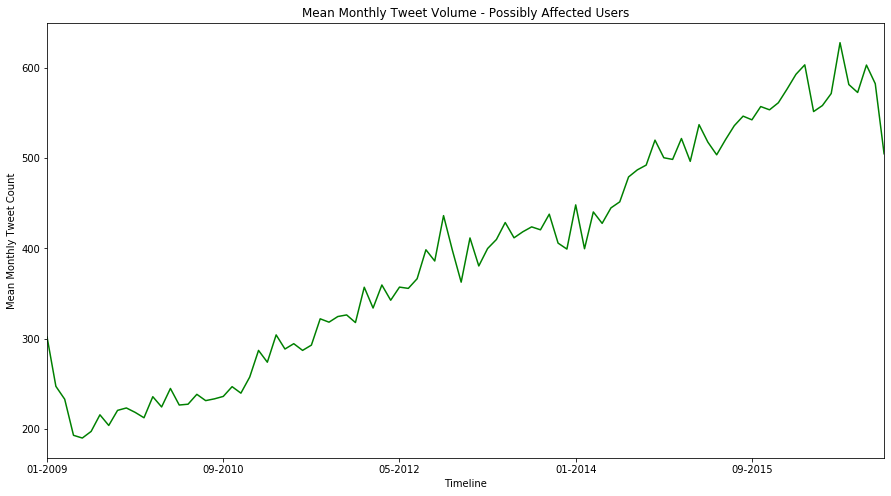

In [24]:
plt.figure()
tweet_countDF.mean().plot(kind='line', color='green', figsize=(15,8),title='Mean Monthly Tweet Volume - Possibly Affected Users')
# plt.legend(('Trump','Hillary'))
plt.ylabel('Mean Monthly Tweet Count')
plt.xlabel('Timeline')
plt.savefig('PAU_graphics/pau_tweetcount.png')
plt.show()

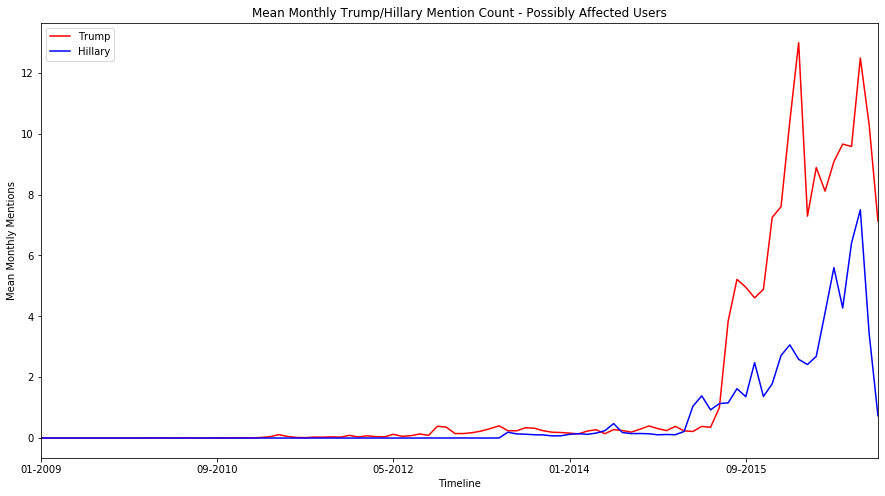

In [25]:
plt.figure()
trump_countDF.mean().plot(kind='line', color='red', figsize=(15,8),title='Mean Monthly Trump/Hillary Mention Count - Possibly Affected Users')
clinton_countDF.mean().plot(kind='line', color='blue', figsize=(15,8))
plt.legend(('Trump','Hillary'))
plt.ylabel('Mean Monthly Mentions')
plt.savefig('PAU_graphics/pau_mentions.png')
plt.xlabel('Timeline')
plt.show()

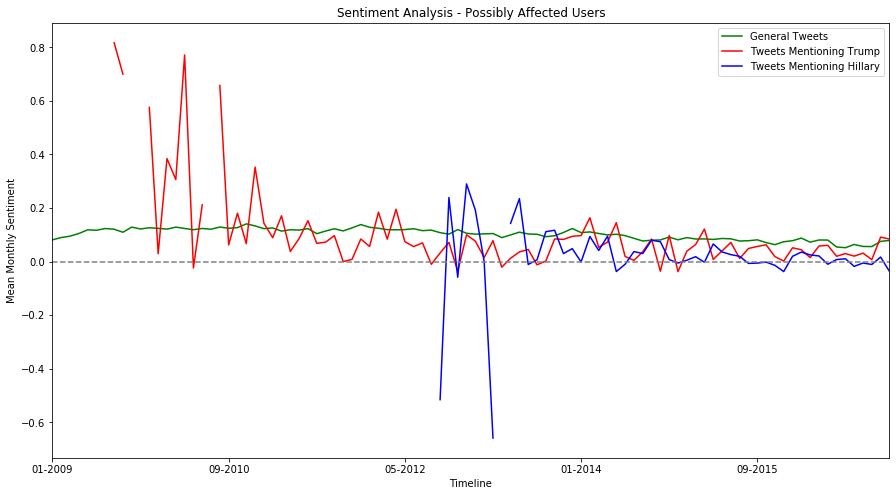

In [26]:
plt.figure()
sentiment_scoresDF.mean().plot(kind='line', color='green', figsize=(15,8),title='Sentiment Analysis - Possibly Affected Users')
trump_sentDF.mean().plot(kind='line', color='red', figsize=(15,8))
clinton_sentDF.mean().plot(kind='line', color='blue', figsize=(15,8))
plt.legend(('General Tweets','Tweets Mentioning Trump','Tweets Mentioning Hillary'))
plt.axhline(0, color="grey", linestyle="--")
plt.ylabel('Mean Monthly Sentiment')
plt.savefig('PAU_graphics/pau_sentiment.png')
plt.xlabel('Timeline')
plt.show()